<a href="https://colab.research.google.com/github/victorm0202/temas_selectos_CD/blob/main/Text_classification_%2B_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An introduction to `torchtext` and embeddings layers for texts

[Torchtext](https://pytorch.org/text/stable/index.html) is a companion package to PyTorch consisting of data processing utilities and popular datasets for natural language.

What we **can do** with Torchtext:

* File Loading: load in the corpus from various formats
* Tokenization: break sentences into list of words
* Vocab: generate a vocabulary list
* Numericalize/Indexify: Map words into integer numbers for the entire corpus
* Word Vector: either initialize vocabulary randomly or load in from a pretrained embedding, this embedding must be “trimmed”, meaning we only store words in our vocabulary into memory.
* Batching: generate batches of training sample (padding is normally happening here)

What we **cannot do** with torchtext: 

* Train/Val/Test Split: seperate your data into a fixed train/val/test set (not used for k-fold validation)
* Embedding Lookup: map each sentence (which contains word indices) to fixed dimension word vectors




## The imports 

In [2]:
import torch
import torchtext

#print("PyTorch Version : {}".format(torch.__version__))
#print("Torch Text Version : {}".format(torchtext.__version__))

In [3]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 8.3 MB/s 
     |████████████████████████████████| 140 kB 59.9 MB/s 
     |████████████████████████████████| 127 kB 64.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## The dataset

We will use AG NEWS dataset available from torchtext library. It has text documents for 4 different categories `["World", "Sports", "Business", "Sci/Tech"]`. The dataset is already divided into train and test sets.

In [3]:
from torch.utils.data import DataLoader
train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
#train_dataset, test_dataset  = torchtext.datasets.YelpReviewFull()

In [6]:
type(train_dataset)

torch.utils.data.datapipes.iter.grouping.ShardingFilterIterDataPipe

## Tokenize Text Data And Build Vocabulary

In [4]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import re

def tokenizer(inp_str): ## This method is one way of creating tokenizer that looks for word tokens
    return re.findall(r"\w+", inp_str)

tokenizer = get_tokenizer("basic_english") ## We'll use tokenizer available from PyTorch

def build_vocab(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocab([train_dataset, test_dataset]), specials=["<PAD>", "<UNK>"])
vocab.set_default_index(vocab["<UNK>"])

In [ ]:
len(vocab)

98636

In [ ]:
tokens = tokenizer("Hello how are you?")
indexes = vocab(tokens)

tokens, indexes

(['hello', 'how', 'are', 'you', '?'], [12389, 356, 43, 165, 81])

In [ ]:
vocab.lookup_indices(tokens)

[12389, 356, 43, 165, 81]

In [ ]:
vocab.lookup_tokens([0,200])

['<PAD>', 'make']

 Set up GPU for Training

In [7]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


## Data Loaders (Vectorize Text Data)

We have decided to keep a maximum of 50 words per document. To handle that condition, we have truncated words from documents that have more than 50 words and padded documents (with zeros) to documents that have less than 50 words. The number of words to keep per document is one of the hyperparameters to train. We have kept it at 50 but different values can be tried to check whether any helps improve the accuracy of the model

In [8]:
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(sample)) for sample in X]
    X = [sample+([0]* (50-len(sample))) if len(sample)<50 else sample[:50] for sample in X] ## Bringing all samples to 50 length.
    return torch.tensor(X, dtype=torch.int32).to(device), torch.tensor(Y).to(device) - 1 ## We have deducted 1 from target names to get them in range [0,1,2,3,5] from [1,2,3,4,5]

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch)
test_loader  = DataLoader(test_dataset, batch_size=1024, collate_fn=vectorize_batch)

In [16]:
len(train_dataset)

120000

In [15]:
118*1024

120832

In [ ]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 50]) torch.Size([1024])


## A model with a simple embedding layer

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
from torch import nn
from torch.nn import functional as F

class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Embedding(num_embeddings=len(vocab), embedding_dim=25),

            nn.Flatten(),

            nn.Linear(25*50, 128), ## 25 = embeding length, 50 = words we kept per text example
            nn.ReLU(),

            nn.Linear(128,64),
            nn.ReLU(),

            nn.Linear(64, len(target_classes)),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

In [11]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in tqdm(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().cpu().numpy(), Y_preds.detach().cpu().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)


### Training and evaluate the model

In [ ]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
embed_classifier = EmbeddingClassifier()
# Send model to `device` (GPU/CPU)
embed_classifier.to(device)
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

TrainModel(embed_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 118/118 [00:03<00:00, 33.07it/s]


Train Loss : 1.201
Valid Loss : 1.019
Valid Acc  : 0.573


100%|██████████| 118/118 [00:03<00:00, 32.01it/s]


Train Loss : 0.846
Valid Loss : 0.779
Valid Acc  : 0.691


100%|██████████| 118/118 [00:03<00:00, 31.69it/s]


Train Loss : 0.609
Valid Loss : 0.653
Valid Acc  : 0.754


100%|██████████| 118/118 [00:03<00:00, 32.63it/s]


Train Loss : 0.456
Valid Loss : 0.591
Valid Acc  : 0.786


100%|██████████| 118/118 [00:03<00:00, 31.99it/s]


Train Loss : 0.348
Valid Loss : 0.577
Valid Acc  : 0.804


100%|██████████| 118/118 [00:03<00:00, 32.21it/s]


Train Loss : 0.264
Valid Loss : 0.604
Valid Acc  : 0.810


100%|██████████| 118/118 [00:03<00:00, 32.56it/s]


Train Loss : 0.197
Valid Loss : 0.668
Valid Acc  : 0.813


100%|██████████| 118/118 [00:03<00:00, 32.91it/s]


Train Loss : 0.153
Valid Loss : 0.722
Valid Acc  : 0.815


100%|██████████| 118/118 [00:03<00:00, 31.89it/s]


Train Loss : 0.137
Valid Loss : 0.769
Valid Acc  : 0.811


100%|██████████| 118/118 [00:03<00:00, 31.52it/s]


Train Loss : 0.106
Valid Loss : 0.808
Valid Acc  : 0.815


100%|██████████| 118/118 [00:03<00:00, 32.72it/s]


Train Loss : 0.084
Valid Loss : 0.913
Valid Acc  : 0.810


100%|██████████| 118/118 [00:03<00:00, 32.38it/s]


Train Loss : 0.078
Valid Loss : 0.896
Valid Acc  : 0.826


100%|██████████| 118/118 [00:03<00:00, 33.19it/s]


Train Loss : 0.071
Valid Loss : 0.912
Valid Acc  : 0.829


100%|██████████| 118/118 [00:03<00:00, 32.18it/s]


Train Loss : 0.052
Valid Loss : 0.936
Valid Acc  : 0.839


100%|██████████| 118/118 [00:03<00:00, 32.56it/s]


Train Loss : 0.035
Valid Loss : 1.052
Valid Acc  : 0.832


In [27]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        X = X.to(device)
        Y = Y.to(device)
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().cpu().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().cpu().numpy()

Y_actual, Y_preds = MakePredictions(embed_classifier, test_loader)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8317105263157895

Classification Report : 
              precision    recall  f1-score   support

       World       0.79      0.89      0.84      1900
      Sports       0.90      0.92      0.91      1900
    Business       0.80      0.76      0.78      1900
    Sci/Tech       0.83      0.76      0.79      1900

    accuracy                           0.83      7600
   macro avg       0.83      0.83      0.83      7600
weighted avg       0.83      0.83      0.83      7600


Confusion Matrix : 
[[1688   82   84   46]
 [  91 1754   29   26]
 [ 207   40 1439  214]
 [ 147   65  248 1440]]


In [ ]:
!pip install scikit-plot

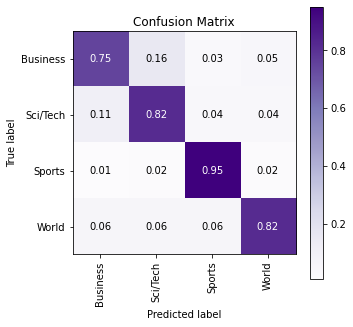

In [ ]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

In [ ]:
!pip install shap
import shap

In [ ]:
def make_predictions2(X_batch_text):
    X_batch = [vocab(tokenizer(sample)) for sample in X_batch_text]
    X_batch = [sample+([0]* (50-len(sample))) if len(sample)<50 else sample[:50] for sample in X_batch] ## Bringing all samples to 50 length.
    X_batch = torch.tensor(X_batch, dtype=torch.int32)
    X_batch = X_batch.to(device)
    logits_preds = embed_classifier(X_batch)
    return F.softmax(logits_preds, dim=-1).detach().cpu().numpy()

masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(make_predictions2, masker=masker, output_names=target_classes)

explainer

In [ ]:
X_test, Y_test = [], []
for Y, X in test_dataset: ## Selecting first 1024 samples from test data
    X_test.append(X)
    Y_test.append(Y-1) ## Please make a Note that we have subtracted 1 from target values to start index from 0 instead of 1.

X_batch = [vocab(tokenizer(sample)) for sample in X_test[:2]]
X_batch = torch.tensor([sample+([0]* (50-len(sample))) if len(sample)<50 else sample[:50] for sample in X_batch], dtype=torch.int32)
X_batch = X_batch.to(device)
logits = embed_classifier(X_batch)
preds_proba = F.softmax(logits, dim=-1)
preds = preds_proba.argmax(dim=-1)


print("Actual    Target Values : {}".format([target_classes[target] for target in Y_test[:2]]))
print("Predicted Target Values : {}".format([target_classes[target] for target in preds]))
print("Predicted Probabilities : {}".format(preds_proba.max(dim=-1)))

Actual    Target Values : ['Business', 'Sci/Tech']
Predicted Target Values : ['World', 'Sci/Tech']
Predicted Probabilities : torch.return_types.max(
values=tensor([0.8250, 1.0000], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0, 3], device='cuda:0'))


In [ ]:
X_batch

tensor([[  888,    12,    84,   138,  1478,    35,   174,  1745,  4023,   401,
            21,  6340, 27377,   230,    68,    43,    17,  4522,    17,    35,
           174,    19, 11465,  2462,   325,   194,  9720,     2,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    3,   490,    22,    11,   126,   921,   113,  1103,   412,  1785,
            12,   749, 10246,    14,   181,     2,   172,    15,   181,     2,
           172,    16,   744,     4,   571,    54,     6, 89243,     7, 25460,
          3944,    12,     3,   475,   205,    83,  5979,  1970,  1120,     4,
             6,  3525, 71992,  8276, 14231,   181,   839,     4,    29,  2400]],
       device='cuda:0', dtype=torch.int32)

In [ ]:
shap_values = explainer(X_test[:2])
shap.text_plot(shap_values)

## A model with Average Word Embeddings

In the first model, we were keeping embeddings for all words/tokens of the text example by laying them next to each other, but in this model, we have taken the average of embeddings of all tokens/words per text example.

In [ ]:
class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.word_embeddings = nn.Embedding(num_embeddings=len(vocab), embedding_dim=25)
        self.linear1 = nn.Linear(25, 128) ## 25 = embeding length, 50 = words we kept per sample
        self.linear2 = nn.Linear(128,64)
        self.linear3 = nn.Linear(64, len(target_classes))

    def forward(self, X_batch):
        x = self.word_embeddings(X_batch)
        x = x.mean(dim=1) ## Averaging embeddings

        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        logits = F.relu(self.linear3(x))

        return logits

### Training and evaluate the model

In [ ]:
from torch.optim import Adam

epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
embed_classifier = EmbeddingClassifier()
embed_classifier.to(device)
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

TrainModel(embed_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 1.339


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 1.216
Valid Acc  : 0.449


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.935


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.698
Valid Acc  : 0.730


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.604


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.548
Valid Acc  : 0.794


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.487


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.477
Valid Acc  : 0.824


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.418


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.433
Valid Acc  : 0.841


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.371


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.402
Valid Acc  : 0.856


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.335


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.380
Valid Acc  : 0.865


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.306


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.363
Valid Acc  : 0.874


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.283


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.350
Valid Acc  : 0.881


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.263


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.340
Valid Acc  : 0.884


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.245


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.332
Valid Acc  : 0.888


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.230


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.326
Valid Acc  : 0.889


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.216


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.322
Valid Acc  : 0.891


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.203


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.318
Valid Acc  : 0.893


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.192


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.316
Valid Acc  : 0.894


In [ ]:
Y_actual, Y_preds = MakePredictions(embed_classifier, test_loader)

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8942105263157895

Classification Report : 
              precision    recall  f1-score   support

       World       0.90      0.90      0.90      1900
      Sports       0.94      0.96      0.95      1900
    Business       0.85      0.87      0.86      1900
    Sci/Tech       0.88      0.84      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600


Confusion Matrix : 
[[1713   59   81   47]
 [  28 1833   25   14]
 [  74   21 1657  148]
 [  86   31  190 1593]]


## A model with pre-trained embeddings (fastText)

We will use fastText pretrained word vectors (Mikolov et al., 2017), trained on 600 billion tokens on Common Crawl. fastText is an upgraded version of word2vec and outperform other state-of-the-art methods by a large margin.

The code below will download fastText pretrained vectors. Using Google Colab, the running time is approximately 3min 30s.

In [7]:
import os
import numpy as np
import pandas as pd

In [8]:
%%time
URL = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
FILE = "fastText"

if os.path.isdir(FILE):
    print("fastText exists.")
else:
    !wget -P $FILE $URL
    !unzip $FILE/crawl-300d-2M.vec.zip -d $FILE

--2022-10-10 01:54:12--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘fastText/crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  59.9MB/s    in 28s     

2022-10-10 01:54:41 (51.5 MB/s) - ‘fastText/crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]

Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  
CPU times: user 526 ms, sys: 118 ms, total: 644 ms
Wall time: 1min 7s


We will load the pretrain vectors for each tokens in our vocabulary. For tokens with no pretraiend vectors, we will initialize random word vectors with the same length and variance.

In [13]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx.lookup_indices(['<pad>'])] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx.lookup_indices([word])] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(vocab)} pretrained vectors found.")

    return embeddings

In [21]:
# Load pretrained vectors
embeddings = load_pretrained_vectors(vocab, "fastText/crawl-300d-2M.vec")
embeddings = torch.tensor(embeddings)
embeddings = embeddings.to(device)

Loading pretrained vectors...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

There are 63068 / 98636 pretrained vectors found.


In [15]:
embeddings.shape

torch.Size([98636, 300])

### The model

In [22]:
from torch import nn
from torch.nn import functional as F

class EmbeddingClassifier(nn.Module):
    def __init__(self, pretrained_emb=None, freeze_embedding=True):
        super(EmbeddingClassifier, self).__init__()
        self.vocab_size, self.embed_dim = pretrained_emb.shape
        self.word_embeddings = nn.Embedding.from_pretrained(pretrained_emb, freeze=freeze_embedding)
        self.linear1 = nn.Linear(self.embed_dim, 128) ## embed_dim = embeding length, 50 = words we kept per sample
        self.linear2 = nn.Linear(128,64)
        self.linear3 = nn.Linear(64, len(target_classes))

    def forward(self, X_batch):
        x = self.word_embeddings(X_batch).float()
        #x = x.permute(0, 2, 1)
        x = x.mean(dim=1) ## Averaging embeddings

        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        logits = F.relu(self.linear3(x))

        return logits

Just to check embedding size...

In [23]:
embed_classifier = EmbeddingClassifier(embeddings, True)
embed_classifier.to(device)
embed_classifier.embed_dim

300

### Training and evaluation

In [34]:
epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
embed_classifier = EmbeddingClassifier(embeddings, True)
embed_classifier.to(device)
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

TrainModel(embed_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.800


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.392
Valid Acc  : 0.880


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.205


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.311
Valid Acc  : 0.906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.171


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.310
Valid Acc  : 0.906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.159


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.315
Valid Acc  : 0.907


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.151


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.321
Valid Acc  : 0.909


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.144


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.324
Valid Acc  : 0.909


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.140


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.327
Valid Acc  : 0.910


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.331
Valid Acc  : 0.910


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.132


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.335
Valid Acc  : 0.911


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.339
Valid Acc  : 0.910


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.127


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.342
Valid Acc  : 0.910


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.126


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.344
Valid Acc  : 0.911


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.124


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.346
Valid Acc  : 0.911


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.123


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.347
Valid Acc  : 0.910


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.122


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.348
Valid Acc  : 0.911


In [35]:
Y_actual, Y_preds = MakePredictions(embed_classifier, test_loader)

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.9107894736842105

Classification Report : 
              precision    recall  f1-score   support

       World       0.92      0.91      0.91      1900
      Sports       0.96      0.98      0.97      1900
    Business       0.88      0.87      0.87      1900
    Sci/Tech       0.88      0.89      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600


Confusion Matrix : 
[[1734   47   66   53]
 [  16 1858   19    7]
 [  76   15 1644  165]
 [  66   12  136 1686]]


A test unfreezing the pre-trained embeddings layer:

In [32]:
epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
embed_classifier = EmbeddingClassifier(embeddings, False)
embed_classifier.to(device)
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

TrainModel(embed_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 1.119


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.937
Valid Acc  : 0.466


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.893


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.880
Valid Acc  : 0.467


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.843


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.862
Valid Acc  : 0.470


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.814


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.878
Valid Acc  : 0.471


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.901
Valid Acc  : 0.470


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.789


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.870
Valid Acc  : 0.465


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.781


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.884
Valid Acc  : 0.448


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.771


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.891
Valid Acc  : 0.446


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.763


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.895
Valid Acc  : 0.459


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.757


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.942
Valid Acc  : 0.464


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.756


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.989
Valid Acc  : 0.468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.756


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 1.074
Valid Acc  : 0.468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.757


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.942
Valid Acc  : 0.464


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.753


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.941
Valid Acc  : 0.461


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/118 [00:00<?, ?it/s]

Train Loss : 0.749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

Valid Loss : 0.938
Valid Acc  : 0.462
